In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.fft import fft, ifft

from sklearn.metrics import r2_score

from ymaeda_tools.read_dGM import read_Mseq1, read_dseq1
from ymaeda_tools.inversion import winv_lstsq
from ymaeda_tools.dft import exidft_timeshift, dft, halfdft_timeshift

# This script verifies that the python functions performing the linear inversion return
# the same results as the original YMAEDA_TOOLS functions

STARTTIME = time.time()

base = "/Volumes/MAC Backup/Final Year Projects/Shinmoedake Data/kirishima_invert/inversion_results_dump_new/"
main_dir = base + "inversion_result_residuals117/t60_p100/x-10900y-121100z1000/"

# time step used by YMAEDA_TOOLS
dt = 0.1 
# frequency step size used by YMAEDA_TOOLS
df = 0.002441406 
# frequency half space used by YMAEDA_TOOLS
f = np.arange(0, df * 2049, df) 
# frequency full space used by YMAEDA_TOOLS
F = np.arange(0, df * 4096, df) 

# read the original M.seq1 output from YMAEDA_TOOLS
mt = read_Mseq1(main_dir)

t = np.arange(0, dt * len(mt), dt)

# load the G and d data and performs inversion using least squares method using the python codes
mest = winv_lstsq(main_dir, w = 0)
print("mest.shape: {}".format(mest.shape))
            
# ifft to time domain. Remember the 1/dt factor, and use time shift of 1000 indices
m = exidft_timeshift(mest, D = 1000) / dt
mr = np.real(m)

print("np.shape(M.seq1): {}, np.shape(mr): {}".format(np.shape(mt), np.shape(mr)))

print("Time elapsed: {:.3f}s".format(time.time() - STARTTIME))

mest.shape: (2049, 2)
np.shape(M.seq1): (4096,), np.shape(mr): (4096,)
Time elapsed: 1.356s


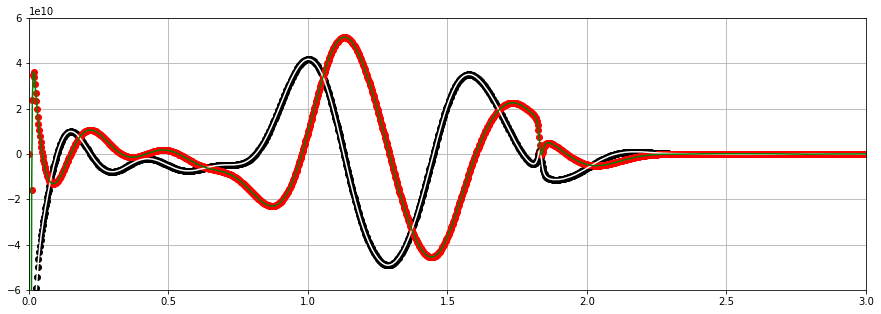

In [2]:
# Test the dft code to check for consistency with the idft code!
mest_rev = halfdft_timeshift(mt, 1000) * dt # don't forget the dt factor!!!
plt.figure(figsize = (15, 5))
plt.plot(f, mest[:,0], "ko")
plt.plot(f, mest[:,1], "ro")
plt.plot(f, np.real(mest_rev),"w")
plt.plot(f, np.imag(mest_rev),"g")
plt.ylim([-0.6e11, 0.6e11])
plt.xlim([0, 3])
plt.grid(True)
plt.show()

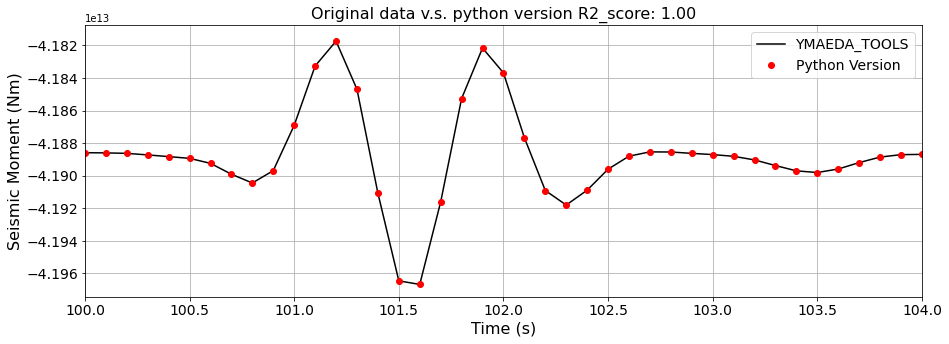

In [3]:
# If the functions were correctly reverse-engineered, mt and mr should be the same (within numerical error)...
plt.figure(figsize = (15, 5))
plt.title("Original data v.s. python version R2_score: {:.2f}".format(r2_score(mt, mr)), fontsize = 16)
plt.plot(t, mt, "k")
plt.plot(t, mr, "ro")
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Seismic Moment (Nm)', fontsize = 16)
plt.legend(["YMAEDA_TOOLS", "Python Version"], fontsize = 14)
plt.grid(True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim([100, 104])
plt.show()

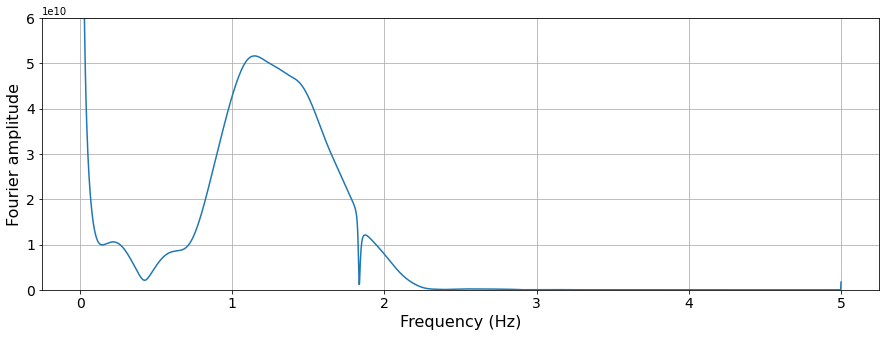

In [4]:
# Check where the most interesting portion of the spectrum is
plt.figure(figsize = (15, 5))
plt.plot(f, np.sqrt(np.abs(mest[:,0]**2 + mest[:,1]**2)))
plt.xlabel("Frequency (Hz)", fontsize = 16)
plt.ylabel("Fourier amplitude", fontsize = 16)
plt.grid(True)
plt.ylim([0, 0.6e11])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

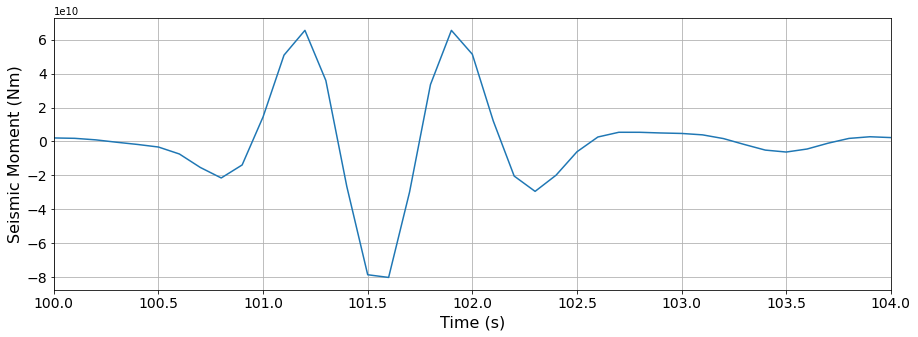

In [10]:
# Try filtering out the ultra-long period signal by focussing on the band [0.5, 2.5] Hz.

b, a = signal.iirfilter(2, [0.5, 2.5], btype='bandpass', analog=False, ftype='butter', fs=1/dt, output='ba')
mt_filt = signal.filtfilt(b, a, mt)

plt.figure(figsize = (15, 5))
plt.plot(t, mt_filt)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Seismic Moment (Nm)', fontsize = 16)
plt.grid(True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim([100, 104])
plt.show()

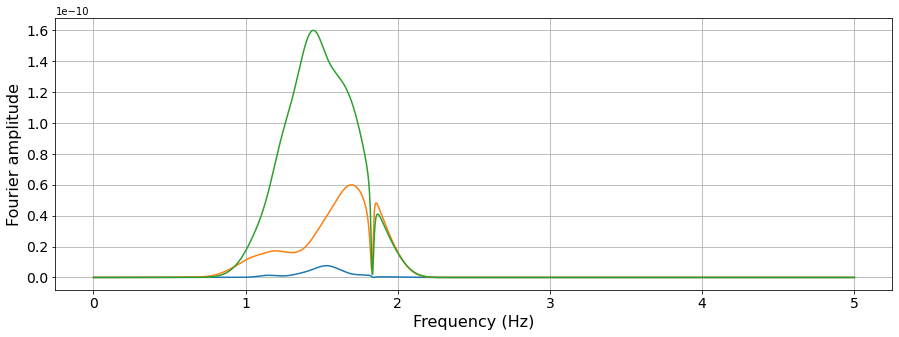

In [6]:
# base directories
base_dir = "/Volumes/MAC Backup/Final Year Projects/Shinmoedake Data/kirishima_invert/"
parent_dir = "inversion_results_dump_new/inversion_result_residuals117/t60_p100/x-10900y-121100z1000/"

# target directory
target_dir = "inv_data_dir_supershort_filtered/"

# wanted station
station = "EV.SMN"

def get_seq1(directory_name):
    if "contribution" in directory_name or "green" in directory_name:
        E_suffix = ".E.sac.M.seq1"
        N_suffix = ".N.sac.M.seq1"
        U_suffix = ".U.sac.M.seq1"
    else:
        E_suffix = ".E.sac.seq1"
        N_suffix = ".N.sac.seq1"
        U_suffix = ".U.sac.seq1"
        
    directory_name = base_dir + parent_dir + directory_name + target_dir
    
    E = read_dseq1(directory_name, station + E_suffix)
    N = read_dseq1(directory_name, station + N_suffix)
    U = read_dseq1(directory_name, station + U_suffix)
    
    t = np.arange(0, len(E) * dt, dt)
    
    return t, E, N, U

t, E, N, U = get_seq1("data_syn/")

fE, aE = signal.periodogram(E, fs = 1/(t[2]-t[1]))
fN, aN = signal.periodogram(N, fs = 1/(t[2]-t[1]))
fU, aU = signal.periodogram(U, fs = 1/(t[2]-t[1]))

plt.figure(figsize = (15, 5))
plt.plot(fE, aE)
plt.plot(fN, aN)
plt.plot(fU, aU)
plt.xlabel("Frequency (Hz)", fontsize = 16)
plt.ylabel("Fourier amplitude", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.show()